In [442]:
import pandas as pd

train_data = pd.read_csv('cure_the_princess_train.csv')
val_data = pd.read_csv('cure_the_princess_validation.csv')
test_data = pd.read_csv('cure_the_princess_test.csv')

In [443]:
import numpy as np

train_data_np = train_data.to_numpy()
val_data_np = val_data.to_numpy()
test_data_np = test_data.to_numpy()


In [444]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)

train_inputs = torch.from_numpy(train_data_np[:, :13]).float().to(device)
train_labels = torch.from_numpy(train_data_np[:, 13]).long().to(device)

val_inputs = torch.from_numpy(val_data_np[:, :13]).float().to(device)
val_labels = torch.from_numpy(val_data_np[:, 13]).long().to(device)

test_inputs = torch.from_numpy(test_data_np[:, :13]).float().to(device)
test_labels = torch.from_numpy(test_data_np[:, 13]).long().to(device)


cuda:0


In [445]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(train_inputs, train_labels)
val_dataset = TensorDataset(val_inputs, val_labels)
test_dataset = TensorDataset(test_inputs, test_labels)

batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [446]:
import torch.nn as nn

torch.manual_seed(190401055)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden_layer_1 = nn.Linear(13, 100)
        self.hidden_layer_2 = nn.Linear(100, 50)
        self.output_layer = nn.Linear(50, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer_1(x))
        x = self.relu(self.hidden_layer_2(x))
        x = self.sigmoid(self.output_layer(x))
        return x

model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [447]:
train_losses = []
val_losses = []
num_epochs = 1000
patience = 25
best_val_loss = np.inf
patience_counter = 0
best_model = None

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for inputs, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)
    
    val_loss = 0.0
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1).float())
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping after {epoch + 1} epochs')
                break

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Patience: {patience_counter}')

torch.save(best_model, 'best_model.pt')



Epoch 1/1000, Train Loss: 0.6750, Val Loss: 0.6441, Patience: 0
Epoch 2/1000, Train Loss: 0.6251, Val Loss: 0.6048, Patience: 0
Epoch 3/1000, Train Loss: 0.5918, Val Loss: 0.5738, Patience: 0
Epoch 4/1000, Train Loss: 0.5643, Val Loss: 0.5464, Patience: 0
Epoch 5/1000, Train Loss: 0.5397, Val Loss: 0.5221, Patience: 0
Epoch 6/1000, Train Loss: 0.5169, Val Loss: 0.4984, Patience: 0
Epoch 7/1000, Train Loss: 0.4951, Val Loss: 0.4746, Patience: 0
Epoch 8/1000, Train Loss: 0.4742, Val Loss: 0.4522, Patience: 0
Epoch 9/1000, Train Loss: 0.4543, Val Loss: 0.4309, Patience: 0
Epoch 10/1000, Train Loss: 0.4354, Val Loss: 0.4110, Patience: 0
Epoch 11/1000, Train Loss: 0.4179, Val Loss: 0.3930, Patience: 0
Epoch 12/1000, Train Loss: 0.4015, Val Loss: 0.3762, Patience: 0
Epoch 13/1000, Train Loss: 0.3863, Val Loss: 0.3603, Patience: 0
Epoch 14/1000, Train Loss: 0.3725, Val Loss: 0.3459, Patience: 0
Epoch 15/1000, Train Loss: 0.3598, Val Loss: 0.3326, Patience: 0
Epoch 16/1000, Train Loss: 0.3481,

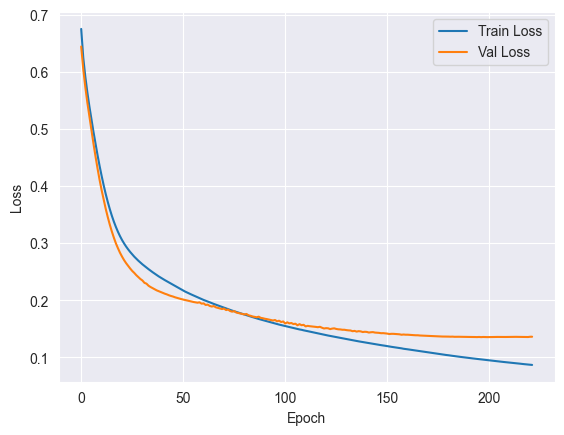

In [448]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('darkgrid')
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [449]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

model.load_state_dict(torch.load('best_model.pt'))

test_predictions = []
test_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        predicted = torch.round(outputs)
        test_predictions.extend(predicted.detach().cpu().numpy())
        test_labels.extend(labels.detach().cpu().numpy())

accuracy = accuracy_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)

print(f'Accuracy: {accuracy:.4f}')
print(f'F1 score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.9443
F1 score: 0.9436
Precision: 0.9600
Recall: 0.9278
